## Семинар: "Методы оптимизации"

In [69]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
import math
%matplotlib inline
plt.rc('animation', html='html5')

In [52]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [3]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

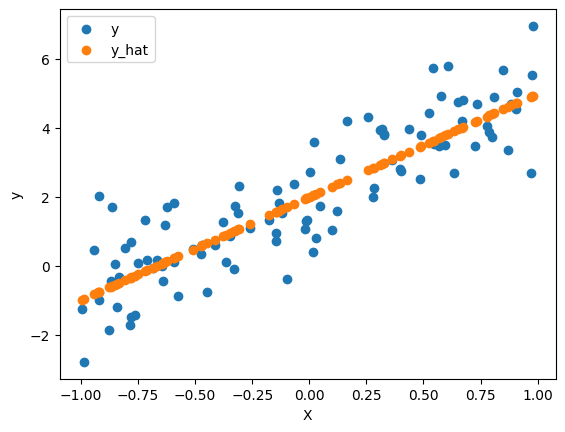

In [4]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

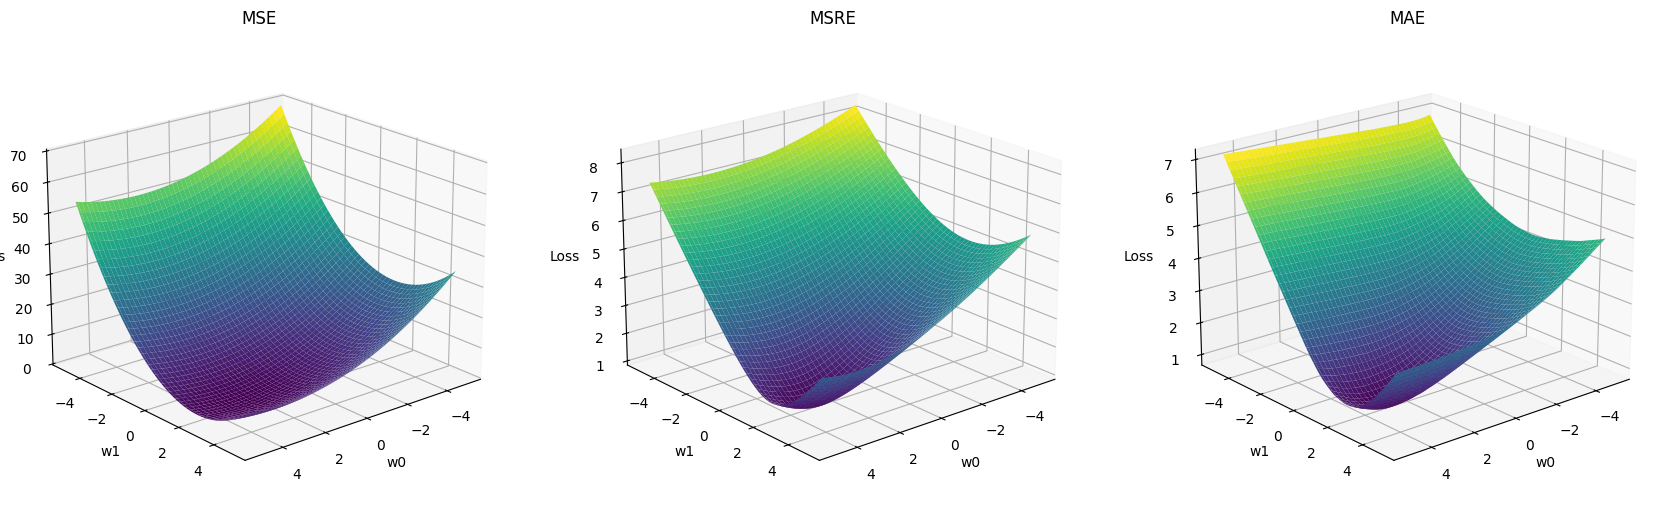

In [5]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [53]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [4]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [8]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [54]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [19]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [7]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [8]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [9]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [70]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2, betas=(0.9, 0.999)):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.betas = betas
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad
                self.m[i] = self.betas[0] * self.m[i] + (1-self.betas[0]) * grad
                self.v[i] = self.betas[1] * self.v[i] + (1-self.betas[1]) * grad ** 2
                p -= self.lr / (torch.sqrt(self.v[i]/(1-self.betas[1]**self.t)) + self.epsilon) * self.m[i]/(1 - self.betas[0]**self.t)

In [71]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2, betas=(0.9, 0.999), weight_decay = 0.01):
        super().__init__(params)
        self.lr = lr 
        self.epsilon = epsilon
        self.betas = betas
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0
        self.weight_decay = weight_decay
    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad
                p -= self.weight_decay*self.lr*p
                self.m[i] = self.betas[0] * self.m[i] + (1-self.betas[0]) * grad
                self.v[i] = self.betas[1] * self.v[i] + (1-self.betas[1]) * grad ** 2
                p -= self.lr / (torch.sqrt(self.v[i]/(1-self.betas[1]**self.t)) + self.epsilon) * self.m[i]/(1 - self.betas[0]**self.t)

In [16]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [17]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

100%|██████████| 5/5 [00:00<00:00, 37.64it/s]


###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [34]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [87]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [86]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [85]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.currtnt_iter = 0
        self.initial_lr = optimizer.lr

    def step(self):
        self.currtnt_iter += 1
        if self.currtnt_iter <= self.total_iters :
            factor = self.start_factor + (self.end_factor - self.start_factor)*( self.currtnt_iter / self.total_iters)
        else:
            factor = self.end_factor
        self.optimizer.lr = self.initial_lr* factor

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            lr_min: float = 0.001
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.lr_min = lr_min
        self.currtnt_iter = 0
        self.initial_lr = optimizer.lr

    def step(self):
        self.currtnt_iter +=1
        self.optimizer.lr = self.lr_min + 0.5 *  (self.initial_lr - self.lr_min)* (1 + math.cos(self.currtnt_iter*math.pi/self.T_max))

In [84]:
def train(model, optimizer, epochs, scheduler=None):
    set_seed(42)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    try:
        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0
            train_correct = 0
            train_total = 0
            for X, y in train_loader:
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                if  scheduler:
                    scheduler.step()
                epoch_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += y.size(0)
                train_correct += (predicted == y).sum().item()
            train_losses.append(epoch_train_loss / len(train_loader))
            train_accuracies.append(100 * train_correct / train_total)
            model.eval()
            epoch_test_loss = 0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for X, y in test_loader:
                    outputs = model(X)
                    loss = criterion(outputs, y)
                    epoch_test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += y.size(0)
                    test_correct += (predicted == y).sum().item()
            test_losses.append(epoch_test_loss / len(test_loader))
            test_accuracies.append(100 * test_correct / test_total)
                
    except KeyboardInterrupt:
        pass
    
    return train_losses, test_losses, train_accuracies, test_accuracies

SGD
Adam
AdamW
SGD-LinearLR
Adam-LinearLR
AdamW-LinearLR
SGD-CosineAnnealing
Adam-CosineAnnealing
AdamW-CosineAnnealing


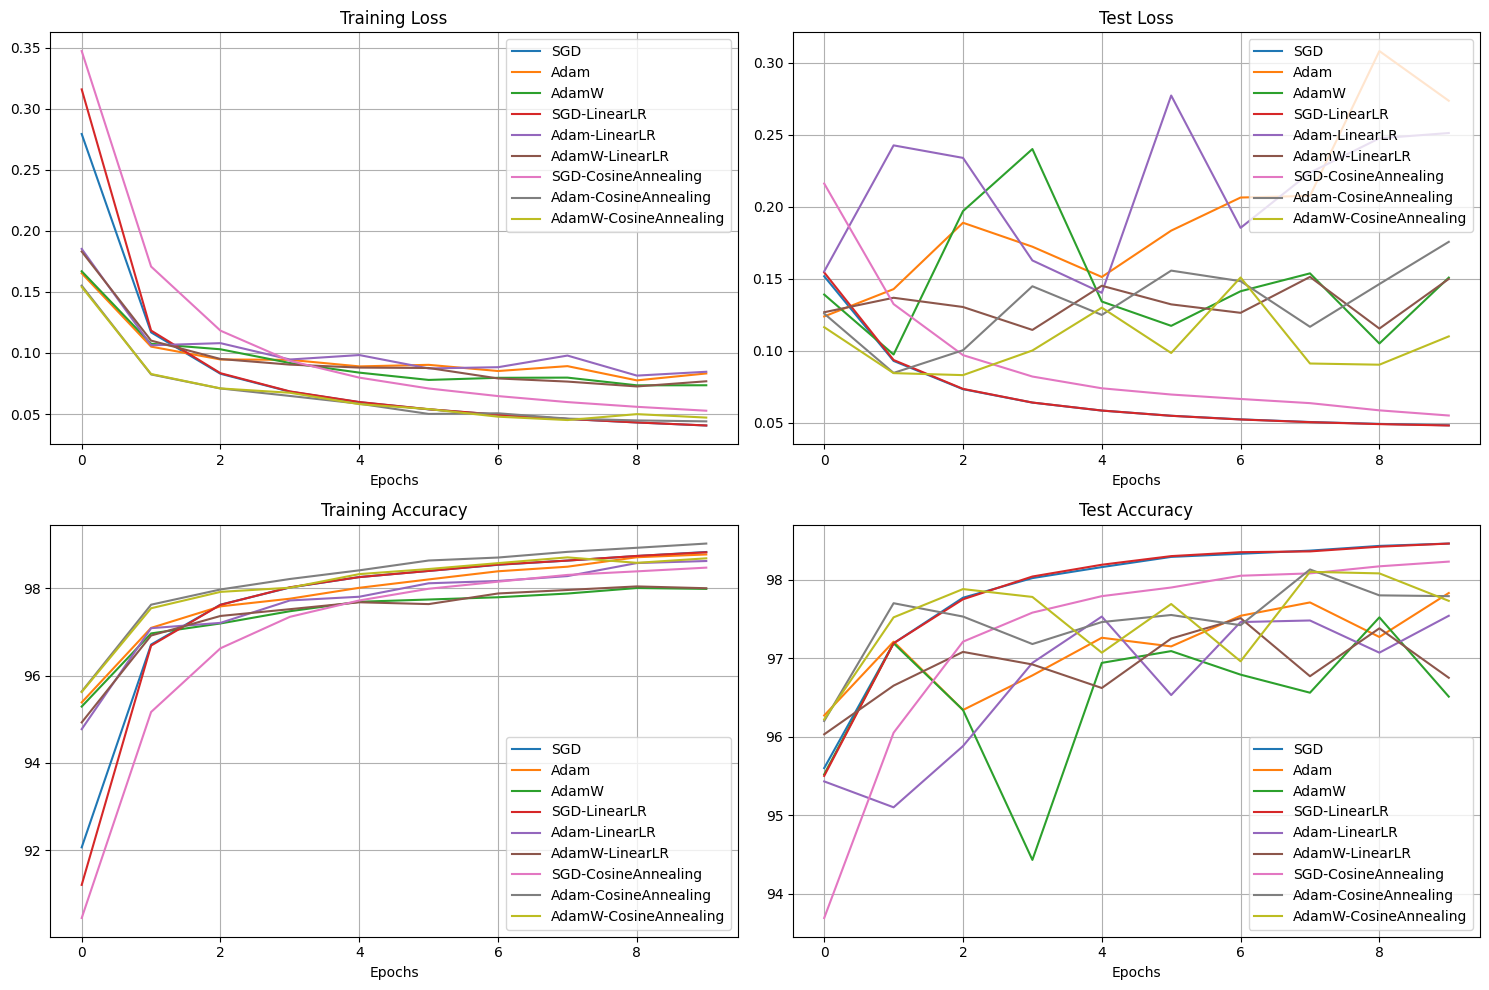


Final Test Accuracies:
SGD: 98.46%
Adam: 97.83%
AdamW: 96.51%
SGD-LinearLR: 98.46%
Adam-LinearLR: 97.54%
AdamW-LinearLR: 96.75%
SGD-CosineAnnealing: 98.23%
Adam-CosineAnnealing: 97.79%
AdamW-CosineAnnealing: 97.73%


In [92]:
def create_model():
    set_seed()
    return nn.Sequential(
        nn.ZeroPad2d(2),
        nn.Conv2d(1, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(16*14*14, 10)
        )

results32 = []

for optimizer_class, name, scheduler_class in [
    (SGD, 'SGD', None),
    (Adam, 'Adam', None),
    (AdamW, 'AdamW', None), 
    (SGD, 'SGD-LinearLR', LinearLR),
    (Adam, 'Adam-LinearLR', LinearLR),
    (AdamW, 'AdamW-LinearLR',LinearLR ), 
    (SGD, 'SGD-CosineAnnealing', CosineAnnealing),
    (Adam, 'Adam-CosineAnnealing', CosineAnnealing),
    (AdamW, 'AdamW-CosineAnnealing', CosineAnnealing)
]:
    print(name)
    model = create_model()
    optimizer = optimizer_class(model.parameters())
    scheduler = None
    if scheduler_class:
        scheduler = scheduler_class(optimizer)
    train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, epochs=10, scheduler=scheduler)
    results32.append({
        'name': name,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    })
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in results32:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in results32:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in results32:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in results32:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in results32:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

Явный трындец с переобучением и скаканием вокруг минимума у adam и adamw

In [93]:
import pickle

def save_results(results, filename):
    with open(filename, 'wb') as file:
        pickle.dump(results, file)

def load_results(filename):
    try:
        with open(filename, 'rb') as file:
            results = pickle.load(file)
        return results
    except FileNotFoundError:
        return {}
    except Exception as e:
        print(e)
        return {}

save_results(results32, 'results32-5.pkl')
    

# loaded_results = load_results('results.pkl')


Сохранил результат 

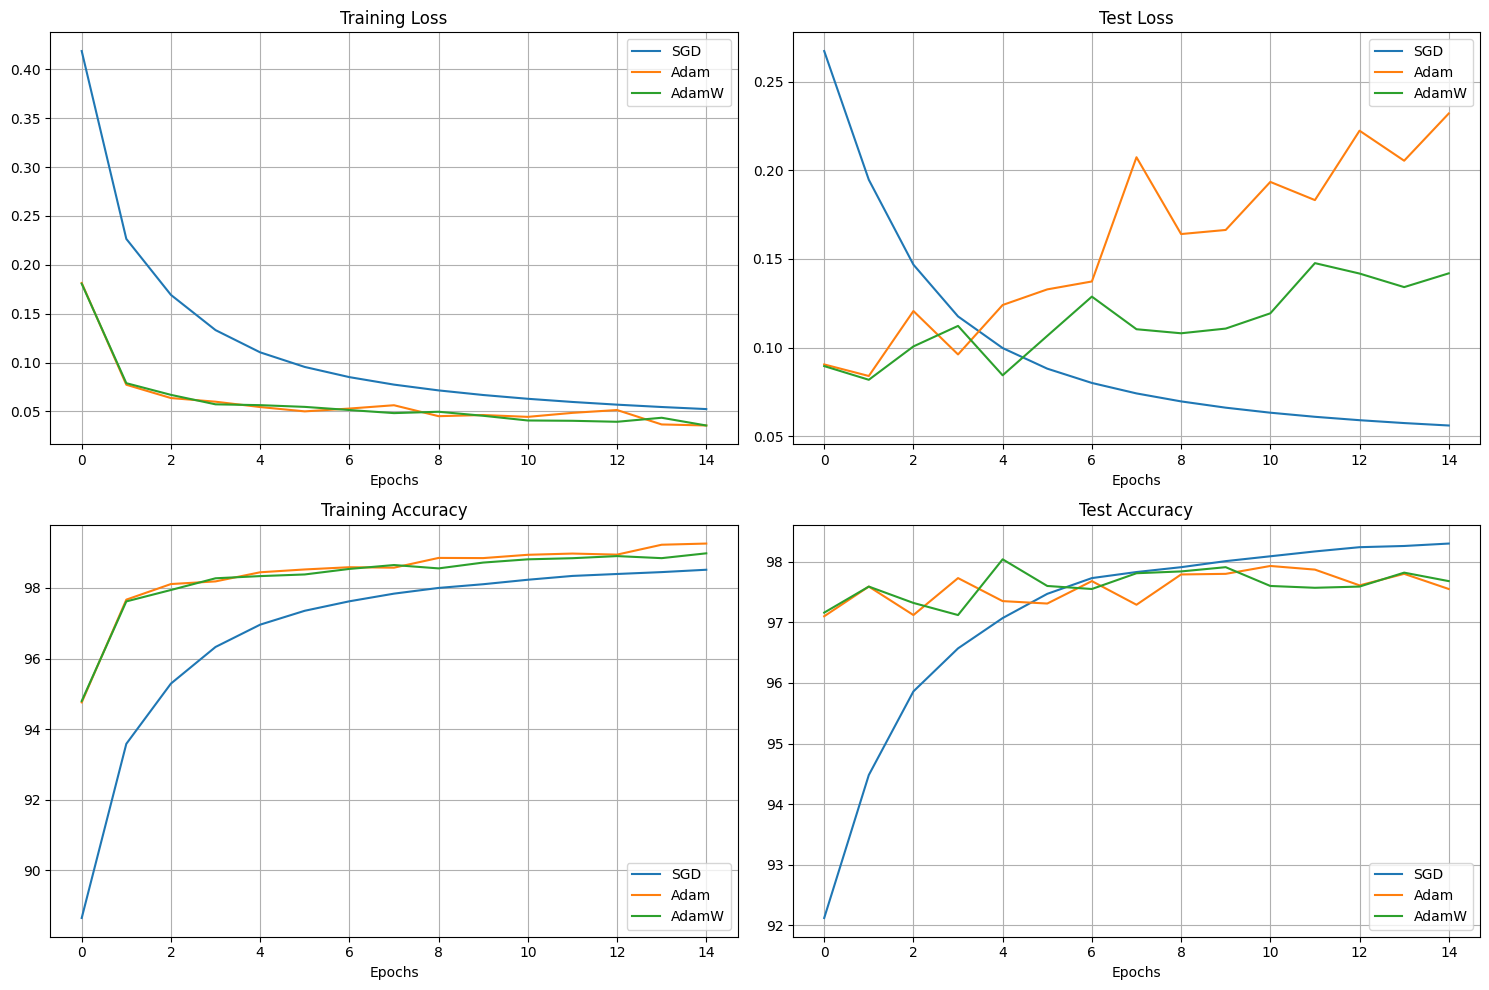


Final Test Accuracies:
SGD: 98.30%
Adam: 97.55%
AdamW: 97.68%


In [89]:
resultsNone = results[0:3]
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in resultsNone:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in resultsNone:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in resultsNone:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in resultsNone:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in resultsNone:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

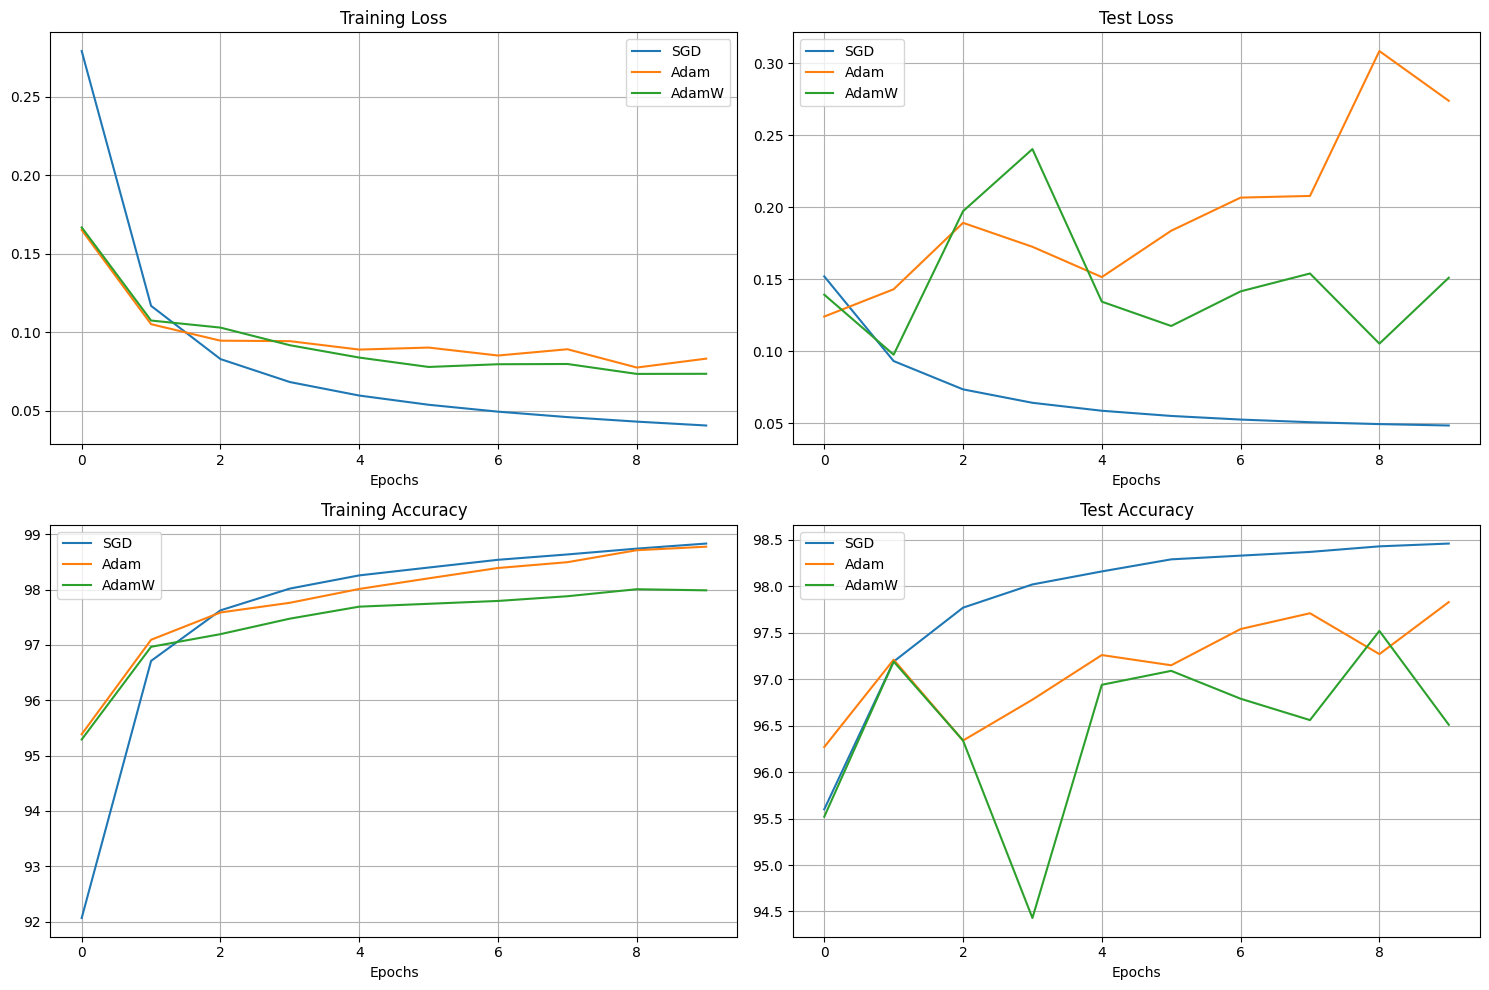


Final Test Accuracies:
SGD: 98.46%
Adam: 97.83%
AdamW: 96.51%


In [94]:
resultsNone = results32[0:3]
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in resultsNone:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in resultsNone:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in resultsNone:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in resultsNone:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in resultsNone:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

адам с первой эпохи сильнее натренировался но потом не попал в минимум

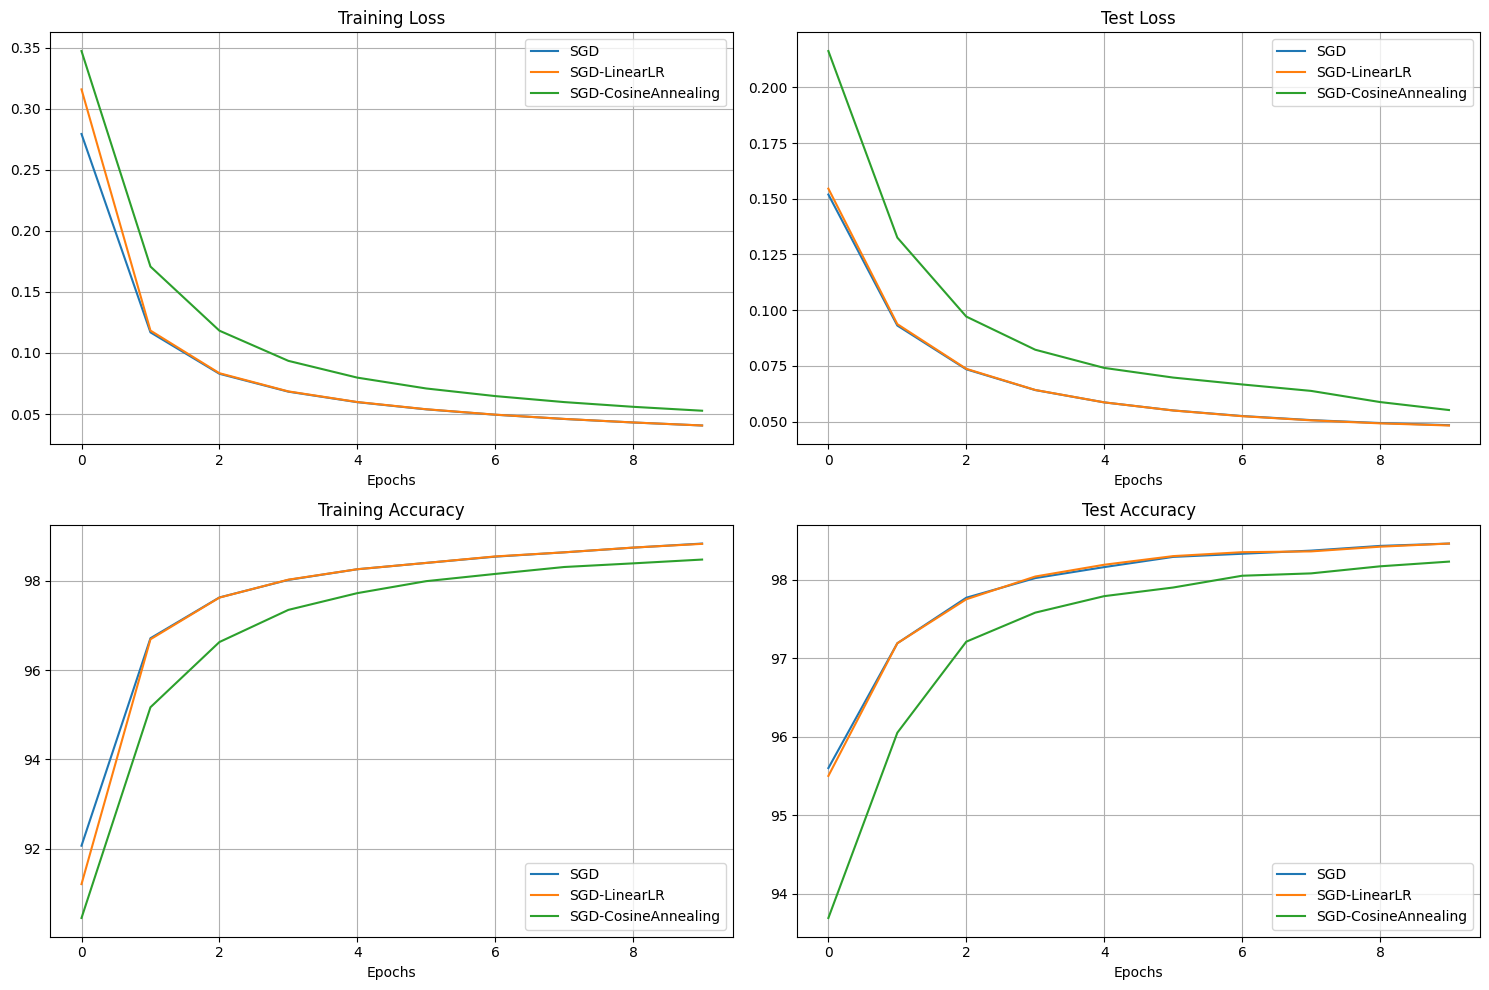


Final Test Accuracies:
SGD: 98.46%
SGD-LinearLR: 98.46%
SGD-CosineAnnealing: 98.23%


In [98]:
resultsLinear = [results32[0], results32[3], results32[6]]
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in resultsLinear:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in resultsLinear:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in resultsLinear:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in resultsLinear:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in resultsLinear:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

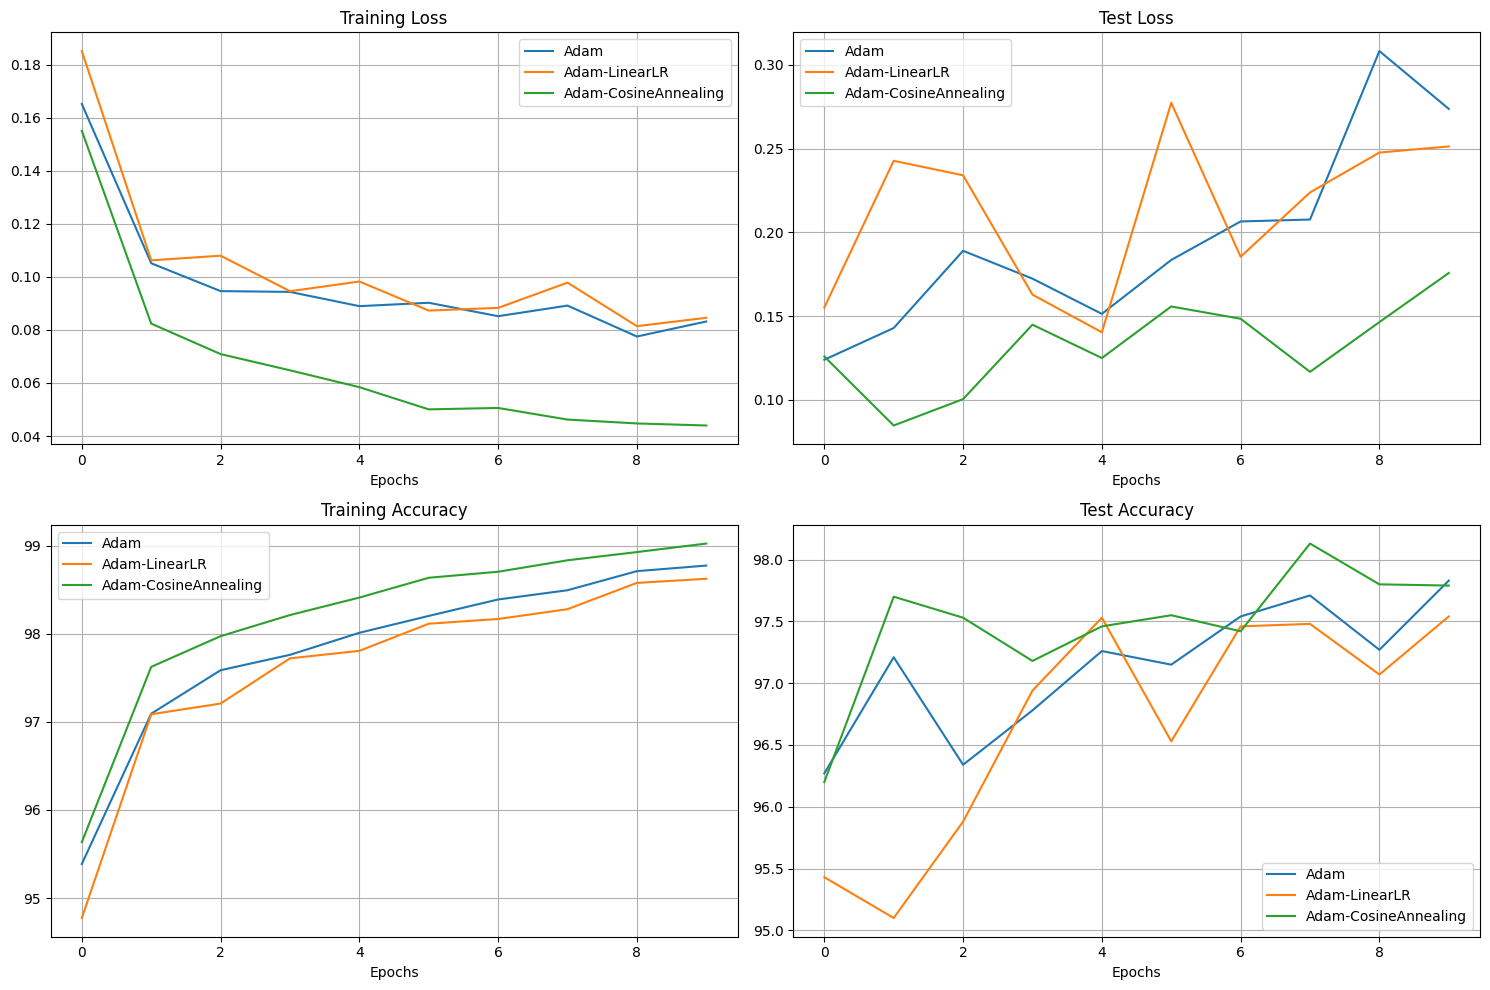


Final Test Accuracies:
Adam: 97.83%
Adam-LinearLR: 97.54%
Adam-CosineAnnealing: 97.79%


In [100]:
resultsLinear = [results32[1], results32[4], results32[7]]
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in resultsLinear:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in resultsLinear:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in resultsLinear:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in resultsLinear:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in resultsLinear:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

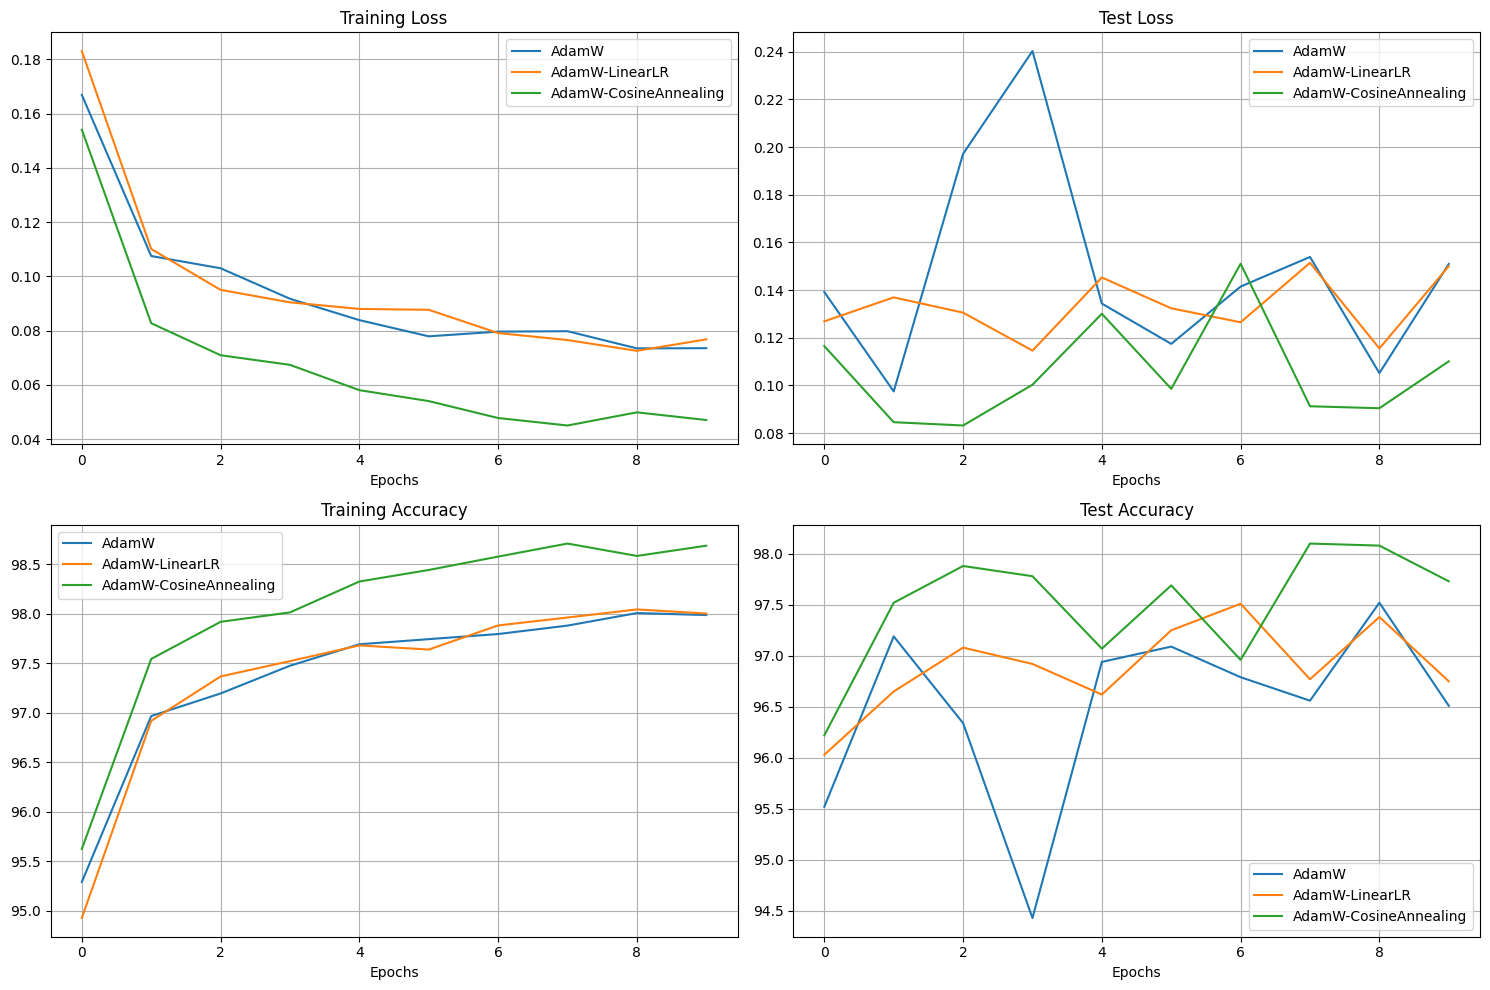


Final Test Accuracies:
AdamW: 96.51%
AdamW-LinearLR: 96.75%
AdamW-CosineAnnealing: 97.73%


In [102]:
resultsLinear = [results32[2], results32[5], results32[8]]
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
for result in resultsLinear:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
for result in resultsLinear:
    plt.plot(result['test_losses'], label=result['name'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
for result in resultsLinear:
    plt.plot(result['train_accuracies'], label=result['name'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
for result in resultsLinear:
    plt.plot(result['test_accuracies'], label=result['name'])
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("\nFinal Test Accuracies:")
for result in resultsLinear:
    print(f"{result['name']}: {result['test_accuracies'][-1]:.2f}%")

Линейное изменения скорости обучения во всех случаях не понесло сильного результата, косинусное изменение в случае сгд только замедлило обучение, а в случае adam и adamW ускорило его и уменьшило "колебания" вокруг минимума

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here